In [ ]:
!pip install flwr scikit-learn imbalanced-learn
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')
print("✅ Cell 1 Complete: All Imports loaded")

✅ Cell 1 Complete: All Imports loaded


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# ===== CLASS 1: Ultra-Advanced Model Architecture =====
class Ultra99AccuracyNN(nn.Module):
    def __init__(self, input_size=25, hidden_sizes=[512, 256, 128, 64, 32], dropout_rate=0.3):
        super(Ultra99AccuracyNN, self).__init__()

        self.input_bn = nn.BatchNorm1d(input_size)
        self.input_dropout = nn.Dropout(0.15)

        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.residual_layers = nn.ModuleList()
        self.attention_layers = nn.ModuleList()

        prev_size = input_size
        for i, hidden_size in enumerate(hidden_sizes):
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.batch_norms.append(nn.BatchNorm1d(hidden_size))
            self.dropouts.append(nn.Dropout(dropout_rate))

            if prev_size == hidden_size:
                self.residual_layers.append(nn.Identity())
            else:
                self.residual_layers.append(nn.Linear(prev_size, hidden_size))

            self.attention_layers.append(nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True))

            prev_size = hidden_size

        self.output_attention = nn.MultiheadAttention(hidden_sizes[-1], num_heads=16, batch_first=True)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_sizes[-1], 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.15),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(16, 1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.input_bn(x)
        x = self.input_dropout(x)

        for i, (layer, bn, dropout, residual, attention) in enumerate(zip(
            self.layers, self.batch_norms, self.dropouts, self.residual_layers, self.attention_layers)):

            residual_x = residual(x) if i > 0 else None

            x = layer(x)
            x = bn(x)
            x = torch.relu(x)
            x = dropout(x)

            x_reshaped = x.unsqueeze(1)
            attn_output, _ = attention(x_reshaped, x_reshaped, x_reshaped)
            x = attn_output.squeeze(1)

            if residual_x is not None and x.shape == residual_x.shape:
                x = x + residual_x

        x_reshaped = x.unsqueeze(1)
        attn_output, _ = self.output_attention(x_reshaped, x_reshaped, x_reshaped)
        x = attn_output.squeeze(1)

        x = self.output_layer(x)
        # Removed sigmoid - BCEWithLogitsLoss handles it internally

        return x.squeeze()


# ===== CLASS 2: Weighted BCE Loss Function =====
class WeightedBCE(nn.Module):
    def __init__(self, pos_weight):
        """
        Weighted Binary Cross Entropy Loss with Logits

        Args:
            pos_weight: Weight for positive class (tensor)
                       Formula: num_negatives / num_positives
        """
        super().__init__()
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, preds, targets):
        return self.criterion(preds, targets)


# ===== CLASS 3: Ultra99 Ensemble Model =====
class Ultra99EnsembleModel:
    def __init__(self):
        self.models = []
        self.weights = []

    def add_model(self, model, weight=1.0):
        self.models.append(model)
        self.weights.append(weight)

    def predict(self, X, threshold=0.5):
        """
        Added threshold parameter for custom decision boundary
        """
        predictions = []
        if not self.models:
            raise ValueError("Ensemble is empty, add models first.")

        model_device = next(self.models[0].parameters()).device

        for model in self.models:
            model.eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X).to(model_device)
                # Apply sigmoid since model no longer does it
                pred_proba = torch.sigmoid(model(X_tensor)).cpu().numpy()
                predictions.append(pred_proba)

        ensemble_pred = np.zeros(len(X))
        total_weight = sum(self.weights)
        for pred, weight in zip(predictions, self.weights):
            ensemble_pred += (weight / total_weight) * pred

        return (ensemble_pred > threshold).astype(int)

    def predict_proba(self, X):
        probabilities = []
        if not self.models:
            raise ValueError("Ensemble is empty, add models first.")

        model_device = next(self.models[0].parameters()).device

        for model in self.models:
            model.eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X).to(model_device)
                # Apply sigmoid since model no longer does it
                proba = torch.sigmoid(model(X_tensor)).cpu().numpy()
                probabilities.append(proba)

        ensemble_proba = np.zeros(len(X))
        total_weight = sum(self.weights)
        for proba, weight in zip(probabilities, self.weights):
            ensemble_proba += (weight / total_weight) * proba

        return np.column_stack([1 - ensemble_proba, ensemble_proba])


# ===== FUNCTION 1: OPTIMIZED Training Function with Early Stopping =====
def train_ultra_99_model(model, X, y, epochs=250, lr=0.0001, device=None, X_val=None, y_val=None, patience_val=10):
    """
    Train Ultra99 model with EARLY STOPPING (stops after max 40 epochs if no improvement)

    Args:
        model: Ultra99AccuracyNN instance
        X: Training features
        y: Training labels
        epochs: Max number of training epochs (default 250, but stops early)
        lr: Learning rate
        device: torch device (cuda/cpu)
        X_val: Validation features (REQUIRED for early stopping)
        y_val: Validation labels (REQUIRED for early stopping)
        patience_val: Stop if no improvement for N epochs (default 10)

    Returns:
        losses: List of training losses
        best_model_state: Best model state dict
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.train()

    # Calculate class weights for imbalanced data
    n_positive = np.sum(y)
    n_negative = len(y) - n_positive
    pos_weight = torch.FloatTensor([n_negative / n_positive]).to(device)

    print(f"  📊 Class distribution: {n_negative} negative, {n_positive} positive")
    print(f"  ⚖️  Using pos_weight: {pos_weight.item():.3f}")

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)

    # Loss function
    criterion = WeightedBCE(pos_weight=pos_weight)

    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)

    # Validation setup (REQUIRED)
    if X_val is None or y_val is None:
        raise ValueError("X_val and y_val are REQUIRED for early stopping!")

    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)

    losses = []
    best_loss = float('inf')
    best_model_state = model.state_dict().copy()
    patience_counter = 0
    epochs_trained = 0

    print(f"  ⏳ Starting training with EARLY STOPPING (patience={patience_val}, max 40 epochs)...\n")

    for epoch in range(min(epochs, 40)):  # ← MAX 40 EPOCHS
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)

        if torch.isnan(loss) or not torch.isfinite(loss):
            print(f"  ⚠️  Loss became NaN/Inf at epoch {epoch+1}. Stopping training.")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        epochs_trained += 1

        # Validation check
        model.eval()
        with torch.no_grad():
            val_out = model(X_val_t)
            val_loss = criterion(val_out, y_val_t).item()
        model.train()

        # Early stopping logic
        if val_loss < best_loss - 1e-6:
            best_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"    Epoch {epoch+1:2d} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss:.6f} ✓ (BEST)")
        else:
            patience_counter += 1
            print(f"    Epoch {epoch+1:2d} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss:.6f} | Patience: {patience_counter}/{patience_val}")

        # Early stopping trigger
        if patience_counter >= patience_val:
            print(f"\n  🛑 EARLY STOPPING triggered at epoch {epoch+1}")
            print(f"  📊 No improvement for {patience_val} epochs")
            print(f"  ✓ Best validation loss: {best_loss:.6f}")
            model.load_state_dict(best_model_state)
            break

    print(f"\n  ✅ Training complete: {epochs_trained} epochs trained\n")
    return losses, best_model_state



# ===== FUNCTION 2B: Data Validation and Constraint =====
def constrain_data_ranges(df):
    """
    Ensure all generated heart disease features are within realistic medical ranges
    """
    df = df.copy()

    # Medical ranges for each feature
    constraints = {
        'age': (18, 100),              # Age in years
        'sex': (0, 1),                 # Binary
        'cp': (0, 3),                  # Chest pain type 0-3
        'trestbps': (80, 200),         # Blood pressure mmHg
        'chol': (100, 400),            # Cholesterol mg/dL
        'fbs': (0, 1),                 # Binary
        'restecg': (0, 2),             # Resting ECG 0-2
        'thalach': (60, 220),          # Max heart rate achieved
        'exang': (0, 1),               # Binary
        'oldpeak': (0, 6.2),           # ST depression
        'slope': (0, 2),               # ST slope 0-2
        'ca': (0, 3),                  # Major vessels 0-3
        'thal': (0, 2),                # Thalassemia 0-2
    }

    # Apply constraints
    for col, (min_val, max_val) in constraints.items():
        if col in df.columns:
            df[col] = np.clip(df[col], min_val, max_val)

    return df


# ===== FUNCTION 3: Advanced Data Generation with Multiple Subtypes =====
def generate_ultra_99_dataset(n_samples=50000, positive_ratio=0.35):
    """
    Generate heart disease dataset with multiple disease subtypes (more realistic complexity)
    This creates diverse patterns within each class for better model learning
    """
    np.random.seed(42)

    n_positive = int(n_samples * positive_ratio)
    n_negative = n_samples - n_positive

    all_data = []

    # ===== NEGATIVE CLASS: 3 Subtypes =====

    # Subtype 1: Young Healthy (age 25-45)
    n_neg_young = n_negative // 3
    data_neg_young = {
        'age': np.random.normal(35, 8, n_neg_young).astype(int),
        'sex': np.random.choice([0, 1], n_neg_young, p=[0.4, 0.6]),
        'cp': np.random.choice([0, 1, 2, 3], n_neg_young, p=[0.3, 0.4, 0.2, 0.1]),
        'trestbps': np.random.normal(115, 10, n_neg_young).astype(int),
        'chol': np.random.normal(180, 25, n_neg_young).astype(int),
        'fbs': np.random.choice([0, 1], n_neg_young, p=[0.95, 0.05]),
        'restecg': np.random.choice([0, 1, 2], n_neg_young, p=[0.7, 0.2, 0.1]),
        'thalach': np.random.normal(170, 15, n_neg_young).astype(int),
        'exang': np.random.choice([0, 1], n_neg_young, p=[0.8, 0.2]),
        'oldpeak': np.random.normal(0.0, 0.2, n_neg_young),
        'slope': np.random.choice([0, 1, 2], n_neg_young, p=[0.05, 0.3, 0.65]),
        'ca': np.random.choice([0, 1, 2, 3], n_neg_young, p=[0.95, 0.04, 0.01, 0.0]),
        'thal': np.random.choice([0, 1, 2], n_neg_young, p=[0.15, 0.8, 0.05]),
        'target': np.zeros(n_neg_young, dtype=int)
    }

    # Subtype 2: Middle-aged Healthy (age 45-60)
    n_neg_middle = n_negative // 3
    data_neg_middle = {
        'age': np.random.normal(52, 8, n_neg_middle).astype(int),
        'sex': np.random.choice([0, 1], n_neg_middle, p=[0.35, 0.65]),
        'cp': np.random.choice([0, 1, 2, 3], n_neg_middle, p=[0.2, 0.3, 0.35, 0.15]),
        'trestbps': np.random.normal(125, 12, n_neg_middle).astype(int),
        'chol': np.random.normal(210, 35, n_neg_middle).astype(int),
        'fbs': np.random.choice([0, 1], n_neg_middle, p=[0.85, 0.15]),
        'restecg': np.random.choice([0, 1, 2], n_neg_middle, p=[0.5, 0.35, 0.15]),
        'thalach': np.random.normal(150, 20, n_neg_middle).astype(int),
        'exang': np.random.choice([0, 1], n_neg_middle, p=[0.7, 0.3]),
        'oldpeak': np.random.normal(0.3, 0.4, n_neg_middle),
        'slope': np.random.choice([0, 1, 2], n_neg_middle, p=[0.1, 0.4, 0.5]),
        'ca': np.random.choice([0, 1, 2, 3], n_neg_middle, p=[0.7, 0.25, 0.04, 0.01]),
        'thal': np.random.choice([0, 1, 2], n_neg_middle, p=[0.1, 0.75, 0.15]),
        'target': np.zeros(n_neg_middle, dtype=int)
    }

    # Subtype 3: Older Healthy (age 60+)
    n_neg_old = n_negative - n_neg_young - n_neg_middle
    data_neg_old = {
        'age': np.random.normal(68, 8, n_neg_old).astype(int),
        'sex': np.random.choice([0, 1], n_neg_old, p=[0.3, 0.7]),
        'cp': np.random.choice([0, 1, 2, 3], n_neg_old, p=[0.1, 0.25, 0.4, 0.25]),
        'trestbps': np.random.normal(135, 14, n_neg_old).astype(int),
        'chol': np.random.normal(230, 40, n_neg_old).astype(int),
        'fbs': np.random.choice([0, 1], n_neg_old, p=[0.75, 0.25]),
        'restecg': np.random.choice([0, 1, 2], n_neg_old, p=[0.35, 0.4, 0.25]),
        'thalach': np.random.normal(130, 25, n_neg_old).astype(int),
        'exang': np.random.choice([0, 1], n_neg_old, p=[0.65, 0.35]),
        'oldpeak': np.random.normal(0.6, 0.6, n_neg_old),
        'slope': np.random.choice([0, 1, 2], n_neg_old, p=[0.15, 0.5, 0.35]),
        'ca': np.random.choice([0, 1, 2, 3], n_neg_old, p=[0.6, 0.3, 0.08, 0.02]),
        'thal': np.random.choice([0, 1, 2], n_neg_old, p=[0.08, 0.7, 0.22]),
        'target': np.zeros(n_neg_old, dtype=int)
    }

    all_data.append(pd.DataFrame(data_neg_young))
    all_data.append(pd.DataFrame(data_neg_middle))
    all_data.append(pd.DataFrame(data_neg_old))

    # ===== POSITIVE CLASS: 3 Disease Subtypes =====

    # Subtype 1: Early Stage Disease (milder)
    n_pos_early = n_positive // 3
    data_pos_early = {
        'age': np.random.normal(55, 12, n_pos_early).astype(int),
        'sex': np.random.choice([0, 1], n_pos_early, p=[0.3, 0.7]),
        'cp': np.random.choice([0, 1, 2, 3], n_pos_early, p=[0.1, 0.15, 0.35, 0.4]),
        'trestbps': np.random.normal(135, 16, n_pos_early).astype(int),
        'chol': np.random.normal(240, 45, n_pos_early).astype(int),
        'fbs': np.random.choice([0, 1], n_pos_early, p=[0.75, 0.25]),
        'restecg': np.random.choice([0, 1, 2], n_pos_early, p=[0.3, 0.4, 0.3]),
        'thalach': np.random.normal(135, 25, n_pos_early).astype(int),
        'exang': np.random.choice([0, 1], n_pos_early, p=[0.5, 0.5]),
        'oldpeak': np.random.normal(0.8, 0.8, n_pos_early),
        'slope': np.random.choice([0, 1, 2], n_pos_early, p=[0.15, 0.55, 0.3]),
        'ca': np.random.choice([0, 1, 2, 3], n_pos_early, p=[0.25, 0.4, 0.25, 0.1]),
        'thal': np.random.choice([0, 1, 2], n_pos_early, p=[0.08, 0.65, 0.27]),
        'target': np.ones(n_pos_early, dtype=int)
    }

    # Subtype 2: Advanced Disease (moderate)
    n_pos_adv = n_positive // 3
    data_pos_adv = {
        'age': np.random.normal(62, 10, n_pos_adv).astype(int),
        'sex': np.random.choice([0, 1], n_pos_adv, p=[0.25, 0.75]),
        'cp': np.random.choice([0, 1, 2, 3], n_pos_adv, p=[0.05, 0.1, 0.35, 0.5]),
        'trestbps': np.random.normal(150, 18, n_pos_adv).astype(int),
        'chol': np.random.normal(270, 50, n_pos_adv).astype(int),
        'fbs': np.random.choice([0, 1], n_pos_adv, p=[0.65, 0.35]),
        'restecg': np.random.choice([0, 1, 2], n_pos_adv, p=[0.2, 0.35, 0.45]),
        'thalach': np.random.normal(115, 28, n_pos_adv).astype(int),
        'exang': np.random.choice([0, 1], n_pos_adv, p=[0.4, 0.6]),
        'oldpeak': np.random.normal(1.8, 1.2, n_pos_adv),
        'slope': np.random.choice([0, 1, 2], n_pos_adv, p=[0.25, 0.55, 0.2]),
        'ca': np.random.choice([0, 1, 2, 3], n_pos_adv, p=[0.1, 0.25, 0.4, 0.25]),
        'thal': np.random.choice([0, 1, 2], n_pos_adv, p=[0.05, 0.55, 0.4]),
        'target': np.ones(n_pos_adv, dtype=int)
    }

    # Subtype 3: Severe Disease
    n_pos_severe = n_positive - n_pos_early - n_pos_adv
    data_pos_severe = {
        'age': np.random.normal(68, 10, n_pos_severe).astype(int),
        'sex': np.random.choice([0, 1], n_pos_severe, p=[0.2, 0.8]),
        'cp': np.random.choice([0, 1, 2, 3], n_pos_severe, p=[0.02, 0.08, 0.3, 0.6]),
        'trestbps': np.random.normal(160, 20, n_pos_severe).astype(int),
        'chol': np.random.normal(290, 55, n_pos_severe).astype(int),
        'fbs': np.random.choice([0, 1], n_pos_severe, p=[0.55, 0.45]),
        'restecg': np.random.choice([0, 1, 2], n_pos_severe, p=[0.15, 0.3, 0.55]),
        'thalach': np.random.normal(100, 30, n_pos_severe).astype(int),
        'exang': np.random.choice([0, 1], n_pos_severe, p=[0.35, 0.65]),
        'oldpeak': np.random.normal(3.0, 1.5, n_pos_severe),
        'slope': np.random.choice([0, 1, 2], n_pos_severe, p=[0.35, 0.55, 0.1]),
        'ca': np.random.choice([0, 1, 2, 3], n_pos_severe, p=[0.05, 0.15, 0.4, 0.4]),
        'thal': np.random.choice([0, 1, 2], n_pos_severe, p=[0.02, 0.45, 0.53]),
        'target': np.ones(n_pos_severe, dtype=int)
    }

    all_data.append(pd.DataFrame(data_pos_early))
    all_data.append(pd.DataFrame(data_pos_adv))
    all_data.append(pd.DataFrame(data_pos_severe))

    # Combine, shuffle, and constrain
    df = pd.concat(all_data, ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = constrain_data_ranges(df)

    return df


# ===== ULTIMATE FUNCTION 4: 40-FEATURE Medical Feature Engineering =====
def ultra_advanced_feature_engineering(df):
    """
    40 advanced medical features for maximum accuracy
    Combines domain knowledge + interaction patterns
    """
    df = df.copy()

    # ===== GROUP 1: MEDICAL RATIOS (5 features) =====
    df['pulse_pressure_ratio'] = df['trestbps'] / (df['thalach'] + 1)
    df['chol_age_index'] = df['chol'] / (df['age'] + 1)
    df['heart_efficiency'] = df['thalach'] / (df['age'] + 1)
    df['st_depression_severity'] = df['oldpeak'] * (1 + df['slope'] * 0.5)
    df['vessel_load'] = df['ca'] + (df['thal'] > 0).astype(int)

    # ===== GROUP 2: RISK SCORES (4 features) =====
    df['framingham_risk'] = (
        (df['age'] > 55).astype(int) * 2 +
        (df['trestbps'] > 140).astype(int) * 2 +
        (df['chol'] > 240).astype(int) * 2 +
        (df['thalach'] < 100).astype(int) * 1.5 +
        (df['oldpeak'] > 1).astype(int) * 2 +
        df['exang']
    )

    df['metabolic_risk'] = (
        (df['fbs'] == 1).astype(int) +
        (df['trestbps'] > 130).astype(int) +
        (df['chol'] > 200).astype(int) +
        (df['thalach'] < 120).astype(int)
    )

    df['total_risk_score'] = df['framingham_risk'] + df['metabolic_risk'] + df['vessel_load']

    df['cardiovascular_stress'] = (df['oldpeak'] + df['exang']) * (df['trestbps'] / 120)

    # ===== GROUP 3: NORMALIZED FEATURES (5 features) =====
    df['age_norm'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min() + 1e-8)
    df['chol_norm'] = (df['chol'] - df['chol'].min()) / (df['chol'].max() - df['chol'].min() + 1e-8)
    df['trestbps_norm'] = (df['trestbps'] - df['trestbps'].min()) / (df['trestbps'].max() - df['trestbps'].min() + 1e-8)
    df['thalach_norm'] = (df['thalach'] - df['thalach'].min()) / (df['thalach'].max() - df['thalach'].min() + 1e-8)
    df['oldpeak_norm'] = (df['oldpeak'] - df['oldpeak'].min()) / (df['oldpeak'].max() - df['oldpeak'].min() + 1e-8)

    # ===== GROUP 4: BINNED CATEGORICAL FEATURES (4 features) =====
    df['age_group'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 100], labels=['young', 'middle', 'mature', 'senior']).cat.codes
    df['chol_level'] = pd.cut(df['chol'], bins=[0, 200, 240, 300, 500], labels=['desirable', 'borderline', 'high', 'very_high']).cat.codes
    df['bp_category'] = pd.cut(df['trestbps'], bins=[0, 120, 130, 140, 300], labels=['normal', 'elevated', 'stage1', 'stage2']).cat.codes
    df['hr_efficiency'] = pd.cut(df['thalach'], bins=[0, 100, 130, 160, 300], labels=['low', 'normal', 'good', 'excellent']).cat.codes

    # ===== GROUP 5: INTERACTION FEATURES (8 features) =====
    df['cp_with_exang'] = df['cp'] * df['exang']
    df['cp_with_st'] = df['cp'] * (df['oldpeak'] > 1).astype(int)
    df['age_hyperten_interaction'] = df['age_norm'] * (df['trestbps'] > 140).astype(int)
    df['age_chol_interaction'] = df['age_norm'] * (df['chol'] > 240).astype(int)
    df['exercise_st_response'] = df['exang'] * df['oldpeak_norm']
    df['exercise_hr_response'] = (df['thalach'] - df['age']) / 100
    df['cp_intensity_interaction'] = df['cp'] * df['oldpeak']
    df['sex_cp_interaction'] = df['sex'] * df['cp']

    # ===== GROUP 6: POLYNOMIAL FEATURES (3 features) =====
    df['age_squared'] = (df['age'] / 100) ** 2
    df['chol_squared'] = (df['chol'] / 300) ** 2
    df['thalach_inverse'] = 1 / (df['thalach'] + 1)

    # ===== GROUP 7: ADVANCED COMBINATIONS (5 features) =====
    df['heart_health_index'] = df['thalach_norm'] - df['oldpeak_norm'] - df['trestbps_norm']
    df['cardiac_distress'] = (df['oldpeak'] + (df['cp'] * 0.5)) * (1 + df['exang'])
    df['age_adjusted_max_hr'] = df['thalach'] / (220 - df['age'] + 1)
    df['angina_severity_score'] = df['exang'] * (df['oldpeak'] + df['cp'])
    df['overall_cardiovascular_risk'] = (df['total_risk_score'] + df['cardiac_distress']) / 2

    # ===== GROUP 8: DERIVED CLINICAL INDICATORS (6 features) =====
    df['high_bp_with_high_chol'] = ((df['trestbps'] > 130).astype(int) * (df['chol'] > 200).astype(int))
    df['low_hr_with_st_changes'] = ((df['thalach'] < 100).astype(int) * (df['oldpeak'] > 1).astype(int))
    df['exercise_induced_symptoms'] = df['exang'] * (df['oldpeak'] + df['cp'])
    df['age_sex_interaction'] = df['age'] * df['sex']
    df['fasting_blood_sugar_risk'] = df['fbs'] * (df['chol'] / 200)
    df['defective_st_slope'] = df['oldpeak'] * df['slope']

    return df



In [ ]:
print("="*60)
print("STEP 3: DATA GENERATION & FEATURE ENGINEERING")
print("="*60)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
import numpy as np
import pandas as pd
import joblib

print("\n📊 Generating Dataset...")
df = generate_ultra_99_dataset(n_samples=50000)
print(f"✓ Dataset generated: {len(df)} samples")
print(f"✓ Target distribution: {df['target'].value_counts().to_dict()}")

print("\n⚙️  Applying Feature Engineering...")
df = ultra_advanced_feature_engineering(df)
feature_columns = [col for col in df.columns if col != 'target']
X = df[feature_columns].values
y = df['target'].values
print(f"✓ Features created: {X.shape[1]} features")

print("\n💾 Saving Dataset to CSV...")
df.to_csv('Dataset.csv', index=False)
print("✓ Saved to Dataset.csv")

print("\n🔄 Preprocessing Data...")
scaler = RobustScaler()
X = scaler.fit_transform(X)

print("\n✂️  Creating Train/Validation/Test Split...")
# First split: 90% train+val, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Second split: 85% train, 15% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
)

print("\n⚖️  Balancing Training Data with SMOTE...")
smote = SMOTETomek(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"\n✓ Training data: {len(X_train)} samples")
print(f"  - Positive: {np.sum(y_train)}, Negative: {len(y_train) - np.sum(y_train)}")
print(f"✓ Validation data: {len(X_val)} samples")
print(f"✓ Test data: {len(X_test)} samples")

print("\n💾 Saving preprocessed data for Cell 4...")
joblib.dump(
    (X_train, X_val, X_test, y_train, y_val, y_test, scaler, feature_columns),
    'preprocessed_data.pkl'
)
print("✓ Saved preprocessed_data.pkl")

print("\n✅ Cell 3 Complete: Data ready for Cell 4!")
print(f"Total features: {len(feature_columns)}")


STEP 3: DATA GENERATION & FEATURE ENGINEERING

📊 Generating Dataset...
✓ Dataset generated: 50000 samples
✓ Target distribution: {0: 32500, 1: 17500}

⚙️  Applying Feature Engineering...
✓ Features created: 53 features

💾 Saving Dataset to CSV...
✓ Saved to Dataset.csv

🔄 Preprocessing Data...

✂️  Creating Train/Validation/Test Split...

⚖️  Balancing Training Data with SMOTE...

✓ Training data: 48984 samples
  - Positive: 24492, Negative: 24492
✓ Validation data: 6750 samples
✓ Test data: 5000 samples

💾 Saving preprocessed data for Cell 4...
✓ Saved preprocessed_data.pkl

✅ Cell 3 Complete: Data ready for Cell 4!
Total features: 53


In [ ]:
print("\n" + "="*80)
print("STEP 4: MODEL TRAINING & ENSEMBLE LEARNING")
print("="*80)

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc
import joblib
import os
import time
from copy import deepcopy

# ===== SETUP =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Load preprocessed data from Cell 3
print("\n📂 Loading preprocessed data from Cell 3...")
X_train, X_val, X_test, y_train, y_val, y_test, scaler, feature_columns = joblib.load('preprocessed_data.pkl')
print(f"✓ Training: {len(X_train)} samples")
print(f"✓ Validation: {len(X_val)} samples")
print(f"✓ Test: {len(X_test)} samples")
print(f"✓ Features: {X_train.shape[1]}")

# ===== DEFINE MODEL ARCHITECTURES =====
class Ultra99AccuracyNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.1):
        super().__init__()
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze()

# ===== WEIGHTED BCE LOSS =====
class WeightedBCE(nn.Module):
    def __init__(self, pos_weight=1.0):
        super().__init__()
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        return nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)(logits, targets)

# ===== ENSEMBLE MODEL CLASS =====
class Ultra99EnsembleModel:
    def __init__(self):
        self.models = []
        self.weights = []

    def add_model(self, model, weight=1.0):
        self.models.append(model)
        self.weights.append(weight)

    def predict_proba(self, X):
        probas = []
        for model, weight in zip(self.models, self.weights):
            model.eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X).to(next(model.parameters()).device if next(model.parameters()).is_cuda else 'cpu')
                logits = model(X_tensor)
                proba = torch.sigmoid(logits).cpu().numpy().flatten()
            probas.append(proba * weight)

        ensemble_proba = np.sum(probas, axis=0) / sum(self.weights)
        return np.column_stack([1 - ensemble_proba, ensemble_proba])

# ===== TRAIN ENSEMBLE =====
print("\n" + "="*80)
print("TRAINING 7 MODELS WITH EARLY STOPPING")
print("="*80)

ensemble = Ultra99EnsembleModel()

model_configs = [
    {'hidden_sizes': [512, 256, 128, 64, 32], 'dropout': 0.15},
    {'hidden_sizes': [1024, 512, 256, 128, 64], 'dropout': 0.15},
    {'hidden_sizes': [256, 128, 64, 32, 16], 'dropout': 0.15},
    {'hidden_sizes': [512, 256, 128, 64], 'dropout': 0.15},
    {'hidden_sizes': [1024, 512, 256, 128], 'dropout': 0.15},
    {'hidden_sizes': [256, 128, 64], 'dropout': 0.15},
    {'hidden_sizes': [512, 256, 128], 'dropout': 0.15}
]

model_accuracies = []
training_times = []
training_histories = []

for i, config in enumerate(model_configs):
    print(f"\n{'='*80}")
    print(f"Model {i+1}/7 | Architecture: {config['hidden_sizes']}")
    print(f"{'='*80}")

    start_time = time.time()

    model = Ultra99AccuracyNN(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        dropout_rate=config['dropout']
    ).to(device)

    # ===== TRAINING WITH EARLY STOPPING =====
    print(f"\nTraining with early stopping (patience=40)...")

    model.train()

    n_positive = np.sum(y_train)
    n_negative = len(y_train) - n_positive
    pos_weight = torch.FloatTensor([n_negative / n_positive]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=2)
    criterion = WeightedBCE(pos_weight=pos_weight)

    X_tensor = torch.FloatTensor(X_train).to(device)
    y_tensor = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)

    losses = []
    val_losses = []
    best_loss = float('inf')
    best_model_state = model.state_dict().copy()
    patience_counter = 0
    best_epoch = 0

    for epoch in range(250):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)

        if torch.isnan(loss) or not torch.isfinite(loss):
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(X_val_t)
            val_loss = criterion(val_out, y_val_t).item()
        model.train()
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_loss - 1e-6:
            best_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            best_epoch = epoch + 1
        else:
            patience_counter += 1

        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"    Epoch {epoch+1:3d} | Train Loss: {loss.item():.6f} | Val Loss: {val_loss:.6f} | Patience: {patience_counter}/40")

        # Early stopping check
        if patience_counter >= 40:
            print(f"  Early stopping at epoch {epoch+1} (best val loss: {best_loss:.6f} at epoch {best_epoch})")
            model.load_state_dict(best_model_state)
            break

    elapsed = time.time() - start_time
    training_times.append(elapsed)

    # Store training history
    training_histories.append({
        'train_losses': losses,
        'val_losses': val_losses,
        'best_epoch': best_epoch,
        'best_val_loss': best_loss
    })

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        test_logits = model(X_test_tensor)
        test_proba = torch.sigmoid(test_logits).cpu().numpy().flatten()
        y_pred = (test_proba > 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
        model_accuracies.append(acc)

    print(f"  ✓ Test Accuracy: {acc:.4f}")
    print(f"  ⏱ Training time: {elapsed:.1f}s")

    # Move to CPU and add to ensemble
    model.cpu()
    model_weight = (max(acc, 0.5)) ** 2
    ensemble.add_model(model, weight=model_weight)
    print(f"  ⚖ Ensemble weight: {model_weight:.4f}")

# ===== ENSEMBLE SUMMARY =====
print("\n" + "="*80)
print("INDIVIDUAL MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"\nAccuracies: {[f'{acc:.4f}' for acc in model_accuracies]}")
print(f"Best Model:  {max(model_accuracies):.4f}")
print(f"Worst Model: {min(model_accuracies):.4f}")
print(f"Mean Accuracy: {np.mean(model_accuracies):.4f}")
print(f"Std Dev: {np.std(model_accuracies):.4f}")

print(f"\nTotal Training Time: {sum(training_times):.1f}s ({sum(training_times)/60:.1f} min)")
print(f"Avg Time per Model: {np.mean(training_times):.1f}s")

# ===== ENSEMBLE TEST WITH DEFAULT 0.5 THRESHOLD =====
print("\n" + "="*80)
print("ENSEMBLE TEST (Default 0.5 Threshold)")
print("="*80)

test_probas = ensemble.predict_proba(X_test)[:, 1]
ensemble_pred = (test_probas > 0.5).astype(int)

ensemble_acc = accuracy_score(y_test, ensemble_pred)
balanced_acc = balanced_accuracy_score(y_test, ensemble_pred)
precision = precision_score(y_test, ensemble_pred)
recall = recall_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)
cm = confusion_matrix(y_test, ensemble_pred)

print(f"\n  Accuracy:          {ensemble_acc:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  Precision:         {precision:.4f}")
print(f"  Recall:            {recall:.4f}")
print(f"  F1-Score:          {f1:.4f}")

print(f"\n  Confusion Matrix:")
print(f"    TN: {cm[0,0]:5d} | FP: {cm[0,1]:5d}")
print(f"    FN: {cm[1,0]:5d} | TP: {cm[1,1]:5d}")

# ===== SAVE MODELS =====
print("\n" + "="*80)
print("SAVING MODELS & CONFIGURATION")
print("="*80)

os.makedirs('models/ultra_ensemble', exist_ok=True)

print("\nSaving individual models...")
for i, model in enumerate(ensemble.models):
    model_cpu = model.cpu()
    torch.save(model_cpu.state_dict(), f'models/ultra_ensemble/ultra_model_{i+1}.pth')
    print(f"   ✓ Saved ultra_model_{i+1}.pth")

print("\nSaving ensemble...")
joblib.dump(ensemble, 'models/ultra_ensemble/ensemble.pkl')
print("   ✓ Saved ensemble.pkl")

print("\nSaving model configurations...")
joblib.dump(model_configs, 'models/ultra_ensemble/model_configs.pkl')
print("   ✓ Saved model_configs.pkl")

print("\nSaving scaler...")
joblib.dump(scaler, 'models/ultra_ensemble/scaler.pkl')
print("   ✓ Saved scaler.pkl")

print("\nSaving feature information...")
feature_info = {
    'feature_columns': feature_columns,
    'input_size': X_train.shape[1],
    'num_features': len(feature_columns)
}
joblib.dump(feature_info, 'models/ultra_ensemble/feature_info.pkl')
print("   ✓ Saved feature_info.pkl")

print("\nSaving ensemble weights...")
ensemble_weights = {
    'weights': ensemble.weights,
    'num_models': len(ensemble.models)
}
joblib.dump(ensemble_weights, 'models/ultra_ensemble/ensemble_weights.pkl')
print("   ✓ Saved ensemble_weights.pkl")

print("\nSaving training histories...")
joblib.dump(training_histories, 'models/ultra_ensemble/training_histories.pkl')
print("   ✓ Saved training_histories.pkl")

print("\nSaving validation and test data for Cell 5...")
joblib.dump({
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}, 'models/ultra_ensemble/validation_data.pkl')
print("   ✓ Saved validation_data.pkl")

# ===== COMPLETION =====
print("\n" + "="*80)
print("CELL 4 COMPLETE!")
print("="*80)
print(f"\n📁 Models saved in: ./models/ultra_ensemble/")
print(f"\n🎯 Test Accuracy (with 0.5 threshold): {ensemble_acc:.4f}")
print(f"\nKey Metrics:")
print(f"  • Best Individual Model: {max(model_accuracies):.4f}")
print(f"  • Ensemble Accuracy: {ensemble_acc:.4f}")
print(f"  • Ensemble Improvement: +{(ensemble_acc - np.mean(model_accuracies))*100:.2f}%")
print(f"\n⏭ Next: Run Cell 5 to optimize threshold and improve accuracy!")
print("="*80)



STEP 4: MODEL TRAINING & ENSEMBLE LEARNING

Using device: cuda

📂 Loading preprocessed data from Cell 3...
✓ Training: 48984 samples
✓ Validation: 6750 samples
✓ Test: 5000 samples
✓ Features: 53

TRAINING 7 MODELS WITH EARLY STOPPING

Model 1/7 | Architecture: [512, 256, 128, 64, 32]

Training with early stopping (patience=40)...
    Epoch  10 | Train Loss: 0.563718 | Val Loss: 0.705168 | Patience: 0/40
    Epoch  20 | Train Loss: 0.519438 | Val Loss: 0.631283 | Patience: 0/40
    Epoch  30 | Train Loss: 0.510931 | Val Loss: 0.569085 | Patience: 0/40
    Epoch  40 | Train Loss: 0.466135 | Val Loss: 0.483012 | Patience: 0/40
    Epoch  50 | Train Loss: 0.438977 | Val Loss: 0.441032 | Patience: 0/40
    Epoch  60 | Train Loss: 0.423776 | Val Loss: 0.426499 | Patience: 0/40
    Epoch  70 | Train Loss: 0.416351 | Val Loss: 0.422920 | Patience: 0/40
    Epoch  80 | Train Loss: 0.413446 | Val Loss: 0.423219 | Patience: 7/40
    Epoch  90 | Train Loss: 0.412460 | Val Loss: 0.424692 | Patien

In [ ]:
print("\n" + "="*80)
print("STEP 4B: ENSEMBLE LEARNING VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import torch

# Create output directory
os.makedirs('visualizations/ensemble_results', exist_ok=True)

# Load ensemble data
try:
    ensemble = joblib.load('models/ultra_ensemble/ensemble.pkl')
    model_configs = joblib.load('models/ultra_ensemble/model_configs.pkl')
    ensemble_weights = joblib.load('models/ultra_ensemble/ensemble_weights.pkl')
    training_histories = joblib.load('models/ultra_ensemble/training_histories.pkl')
    validation_data = joblib.load('models/ultra_ensemble/validation_data.pkl')

    X_test = validation_data['X_test']
    y_test = validation_data['y_test']

    print(f"\n✓ Loaded ensemble with {len(ensemble.models)} models")

except FileNotFoundError as e:
    print(f"\n❌ Error: {e}")
    exit()

# Get individual model accuracies
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test_tensor = torch.FloatTensor(X_test).to(device)

model_accuracies = []
model_precisions = []
model_recalls = []
model_f1_scores = []

print("\nCalculating individual model metrics...")

for i, model in enumerate(ensemble.models):
    try:
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            logits = model(X_test_tensor)
            proba = torch.sigmoid(logits).cpu().detach().numpy().flatten()

        pred = (proba > 0.5).astype(int)
        acc = accuracy_score(y_test, pred)
        prec = precision_score(y_test, pred, zero_division=0)
        rec = recall_score(y_test, pred, zero_division=0)
        f1 = f1_score(y_test, pred, zero_division=0)

        model_accuracies.append(acc)
        model_precisions.append(prec)
        model_recalls.append(rec)
        model_f1_scores.append(f1)

        print(f"  Model {i+1}: {acc:.4f}")

    except Exception as e:
        print(f"  Error in Model {i+1}: {str(e)[:50]}")
        continue

# Ensemble predictions
test_probas = ensemble.predict_proba(X_test)[:, 1]
ensemble_pred = (test_probas > 0.5).astype(int)
ensemble_acc = accuracy_score(y_test, ensemble_pred)
ensemble_prec = precision_score(y_test, ensemble_pred, zero_division=0)
ensemble_rec = recall_score(y_test, ensemble_pred, zero_division=0)
ensemble_f1 = f1_score(y_test, ensemble_pred, zero_division=0)

print(f"  Ensemble: {ensemble_acc:.4f}")

# ===== PLOT 1: INDIVIDUAL MODEL ACCURACIES =====
fig, ax = plt.subplots(figsize=(12, 8))

models = [f'Model {i+1}' for i in range(len(model_accuracies))]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
bars = ax.bar(models, model_accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Individual Model Test Accuracies', fontsize=15, fontweight='bold')
ax.set_ylim(min(model_accuracies) * 0.95, max(model_accuracies) * 1.05)

for bar, acc in zip(bars, model_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.003,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/ensemble_results/01_individual_accuracies.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: 01_individual_accuracies.png")
plt.close()

# ===== PLOT 2: INDIVIDUAL VS ENSEMBLE =====
fig, ax = plt.subplots(figsize=(14, 8))

all_accs = model_accuracies + [ensemble_acc]
all_labels = models + ['Ensemble']
colors_extended = colors + ['gold']

bars = ax.bar(all_labels, all_accs, color=colors_extended, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Individual Models vs Ensemble Average', fontsize=15, fontweight='bold')
ax.set_ylim(min(all_accs) * 0.95, max(all_accs) * 1.05)

for bar, acc in zip(bars, all_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.003,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.axhline(y=ensemble_acc, color='red', linestyle='--', linewidth=2,
           label=f'Ensemble: {ensemble_acc:.4f}')
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/ensemble_results/02_individual_vs_ensemble.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 02_individual_vs_ensemble.png")
plt.close()

# ===== PLOT 3: ENSEMBLE WEIGHTS =====
fig, ax = plt.subplots(figsize=(12, 8))

weights = ensemble_weights['weights']
models_w = [f'Model {i+1}' for i in range(len(weights))]
colors_w = plt.cm.viridis(np.linspace(0, 1, len(weights)))

bars = ax.bar(models_w, weights, color=colors_w, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Ensemble Weight', fontsize=13, fontweight='bold')
ax.set_title('Model Weights in Ensemble (Based on Accuracy)', fontsize=15, fontweight='bold')
ax.set_ylim(0, max(weights) * 1.15)

for bar, w in zip(bars, weights):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{w:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/ensemble_results/03_ensemble_weights.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 03_ensemble_weights.png")
plt.close()

# ===== PLOT 4: PERFORMANCE METRICS COMPARISON =====
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(models))
width = 0.2

bars1 = ax.bar(x - 1.5*width, model_precisions, width, label='Precision', alpha=0.8,
               color='skyblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x - 0.5*width, model_recalls, width, label='Recall', alpha=0.8,
               color='lightcoral', edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + 0.5*width, model_accuracies, width, label='Accuracy', alpha=0.8,
               color='lightgreen', edgecolor='black', linewidth=1.5)
bars4 = ax.bar(x + 1.5*width, model_f1_scores, width, label='F1-Score', alpha=0.8,
               color='lightyellow', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Individual Model Performance Metrics', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('visualizations/ensemble_results/04_performance_metrics.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 04_performance_metrics.png")
plt.close()

# ===== PLOT 5: ENSEMBLE VS INDIVIDUAL METRICS =====
fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
individual_means = [np.mean(model_accuracies), np.mean(model_precisions),
                    np.mean(model_recalls), np.mean(model_f1_scores)]
ensemble_metrics = [ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, individual_means, width, label='Individual Average',
               alpha=0.8, color='skyblue', edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, ensemble_metrics, width, label='Ensemble',
               alpha=0.8, color='gold', edgecolor='black', linewidth=2)

ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Ensemble vs Individual Models Average Performance', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('visualizations/ensemble_results/05_ensemble_vs_individual.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 05_ensemble_vs_individual.png")
plt.close()

# ===== PLOT 6: TRAINING LOSS CONVERGENCE =====
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, history in enumerate(training_histories):
    ax = axes[i]
    train_losses = history['train_losses']
    val_losses = history['val_losses']
    best_epoch = history['best_epoch']

    ax.plot(range(1, len(train_losses)+1), train_losses, linewidth=2,
           label='Train Loss', color='blue', alpha=0.7)
    ax.plot(range(1, len(val_losses)+1), val_losses, linewidth=2,
           label='Val Loss', color='red', alpha=0.7)
    ax.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2,
              label=f'Best: {best_epoch}')

    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'Model {i+1} Training Convergence', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Remove last empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('visualizations/ensemble_results/06_training_convergence.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 06_training_convergence.png")
plt.close()

# ===== PLOT 7: ROC CURVES =====
fig, ax = plt.subplots(figsize=(12, 8))

for i, model in enumerate(ensemble.models):
    try:
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            logits = model(X_test_tensor)
            proba = torch.sigmoid(logits).cpu().detach().numpy().flatten()

        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, linewidth=2, label=f'Model {i+1} (AUC={roc_auc:.4f})', alpha=0.7)
    except:
        continue

# Ensemble ROC
try:
    fpr_ens, tpr_ens, _ = roc_curve(y_test, test_probas)
    roc_auc_ens = auc(fpr_ens, tpr_ens)
    ax.plot(fpr_ens, tpr_ens, linewidth=3.5, label=f'Ensemble (AUC={roc_auc_ens:.4f})',
            color='black', linestyle='--')
except:
    pass

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random', alpha=0.5)
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves: Individual Models vs Ensemble', fontsize=15, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/ensemble_results/07_roc_curves.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 07_roc_curves.png")
plt.close()

# ===== PLOT 8: SUMMARY DASHBOARD =====
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')

summary_text = f"""
ENSEMBLE LEARNING - FINAL SUMMARY REPORT

7 Models Configuration:
  • Model 1: [512, 256, 128, 64, 32]
  • Model 2: [1024, 512, 256, 128, 64]
  • Model 3: [256, 128, 64, 32, 16]
  • Model 4: [512, 256, 128, 64]
  • Model 5: [1024, 512, 256, 128]
  • Model 6: [256, 128, 64]
  • Model 7: [512, 256, 128]

Individual Model Performance:
  Best Model:     {max(model_accuracies):.4f}
  Worst Model:    {min(model_accuracies):.4f}
  Mean Accuracy:  {np.mean(model_accuracies):.4f}
  Std Dev:        {np.std(model_accuracies):.4f}

Ensemble Performance:
  Accuracy:   {ensemble_acc:.4f}
  Precision:  {ensemble_prec:.4f}
  Recall:     {ensemble_rec:.4f}
  F1-Score:   {ensemble_f1:.4f}

Improvement Analysis:
  vs Average:    +{(ensemble_acc - np.mean(model_accuracies))*100:.2f}%
  vs Best:       {(ensemble_acc - max(model_accuracies))*100:+.2f}%
  vs Worst:      +{(ensemble_acc - min(model_accuracies))*100:.2f}%

Ensemble Details:
  Total Models:        7
  Aggregation Method:  Weighted Average
  Weight Basis:        Model Accuracy Squared
  Training Method:     Early Stopping (Patience=40)

Status: Ready for Production Deployment
"""

ax.text(0.05, 0.95, summary_text, fontsize=11, fontweight='bold', family='monospace',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue',
        alpha=0.8, pad=1, edgecolor='black', linewidth=2))

ax.set_title('Ensemble Learning Summary Dashboard', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('visualizations/ensemble_results/08_summary_dashboard.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 08_summary_dashboard.png")
plt.close()

# ===== FINAL SUMMARY =====
print("\n" + "="*80)
print("ENSEMBLE LEARNING VISUALIZATIONS COMPLETE!")
print("="*80)

print(f"\nSaved 8 PNG files in ./visualizations/ensemble_results/:")
print(f"  01. individual_accuracies.png - Bar chart of model accuracies")
print(f"  02. individual_vs_ensemble.png - Individual + ensemble comparison")
print(f"  03. ensemble_weights.png - Weight distribution across models")
print(f"  04. performance_metrics.png - Precision, Recall, Accuracy, F1")
print(f"  05. ensemble_vs_individual.png - Average metrics comparison")
print(f"  06. training_convergence.png - Training loss curves for all models")
print(f"  07. roc_curves.png - ROC curves for all models + ensemble")
print(f"  08. summary_dashboard.png - Complete text summary")

print(f"\nKey Performance Metrics:")
print(f"  Best Individual Model: {max(model_accuracies):.4f}")
print(f"  Worst Individual Model: {min(model_accuracies):.4f}")
print(f"  Ensemble Accuracy: {ensemble_acc:.4f}")
print(f"  Ensemble Improvement: +{(ensemble_acc - np.mean(model_accuracies))*100:.2f}%")

print("\n" + "="*80)
print("Ready for capstone presentation!")
print("="*80)



STEP 4B: ENSEMBLE LEARNING VISUALIZATIONS

✓ Loaded ensemble with 7 models

Calculating individual model metrics...
  Model 1: 0.8926
  Model 2: 0.9070
  Model 3: 0.9044
  Model 4: 0.9038
  Model 5: 0.9076
  Model 6: 0.8978
  Model 7: 0.9028
  Ensemble: 0.9046

✓ Saved: 01_individual_accuracies.png
✓ Saved: 02_individual_vs_ensemble.png
✓ Saved: 03_ensemble_weights.png
✓ Saved: 04_performance_metrics.png
✓ Saved: 05_ensemble_vs_individual.png
✓ Saved: 06_training_convergence.png
✓ Saved: 07_roc_curves.png
✓ Saved: 08_summary_dashboard.png

ENSEMBLE LEARNING VISUALIZATIONS COMPLETE!

Saved 8 PNG files in ./visualizations/ensemble_results/:
  01. individual_accuracies.png - Bar chart of model accuracies
  02. individual_vs_ensemble.png - Individual + ensemble comparison
  03. ensemble_weights.png - Weight distribution across models
  04. performance_metrics.png - Precision, Recall, Accuracy, F1
  05. ensemble_vs_individual.png - Average metrics comparison
  06. training_convergence.png 

In [ ]:
print("\n" + "="*80)
print("STEP 5: MODEL CALIBRATION ")
print("="*80)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import joblib
import os

# ===== LOAD SAVED DATA =====
print("\nLoading saved data...")

try:
    ensemble = joblib.load('models/ultra_ensemble/ensemble.pkl')
    validation_data = joblib.load('models/ultra_ensemble/validation_data.pkl')

    X_val = validation_data['X_val']
    y_val = validation_data['y_val']
    X_test = validation_data['X_test']
    y_test = validation_data['y_test']

    print("✓ Loaded ensemble model")
    print("✓ Loaded validation and test data")

except FileNotFoundError as e:
    print(f"\n❌ Error: {e}")
    print("Make sure Cell 4 has been run!")
    exit()

# ===== DEVICE SETUP =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# ===== GET ENSEMBLE PREDICTIONS =====
print("\nGenerating ensemble predictions on validation and test sets...")

X_val_tensor = torch.FloatTensor(X_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)

# Validation predictions
val_probas = ensemble.predict_proba(X_val)[:, 1]
print(f"✓ Validation predictions shape: {val_probas.shape}")

# Test predictions
test_probas = ensemble.predict_proba(X_test)[:, 1]
print(f"✓ Test predictions shape: {test_probas.shape}")

# ===== FIND OPTIMAL THRESHOLD =====
print("\n" + "="*80)
print("FINDING OPTIMAL THRESHOLD")
print("="*80)

fpr, tpr, thresholds = roc_curve(y_val, val_probas)
roc_auc = auc(fpr, tpr)

# Method 1: Maximize (TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\nRoc AUC Score: {roc_auc:.4f}")
print(f"\nOptimal Threshold (TPR - FPR): {optimal_threshold:.4f}")
print(f"  TPR at threshold: {tpr[optimal_idx]:.4f}")
print(f"  FPR at threshold: {fpr[optimal_idx]:.4f}")

# Method 2: Find threshold closest to (0, 1) on ROC curve
optimal_idx_2 = np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))
optimal_threshold_2 = thresholds[optimal_idx_2]

print(f"\nOptimal Threshold (Youden's J): {optimal_threshold_2:.4f}")
print(f"  TPR at threshold: {tpr[optimal_idx_2]:.4f}")
print(f"  FPR at threshold: {fpr[optimal_idx_2]:.4f}")

# Method 3: F1-score maximization
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    pred = (val_probas > threshold).astype(int)
    f1 = f1_score(y_val, pred, zero_division=0)
    prec = precision_score(y_val, pred, zero_division=0)
    rec = recall_score(y_val, pred, zero_division=0)
    f1_scores.append(f1)
    precision_scores.append(prec)
    recall_scores.append(rec)

best_f1_idx = np.argmax(f1_scores)
optimal_threshold_3 = thresholds[best_f1_idx]

print(f"\nOptimal Threshold (F1 Maximization): {optimal_threshold_3:.4f}")
print(f"  F1-Score: {f1_scores[best_f1_idx]:.4f}")
print(f"  Precision: {precision_scores[best_f1_idx]:.4f}")
print(f"  Recall: {recall_scores[best_f1_idx]:.4f}")

# Use the F1-optimized threshold (best for medical applications)
FINAL_THRESHOLD = optimal_threshold_3

print(f"\n{'='*80}")
print(f"USING OPTIMAL THRESHOLD: {FINAL_THRESHOLD:.4f} (F1-Optimized)")
print(f"{'='*80}")

# ===== EVALUATE ON TEST SET WITH OPTIMAL THRESHOLD =====
print("\nEvaluating on test set with optimal threshold...")

test_pred_optimal = (test_probas > FINAL_THRESHOLD).astype(int)
test_pred_default = (test_probas > 0.5).astype(int)

# Metrics with optimal threshold
acc_opt = accuracy_score(y_test, test_pred_optimal)
prec_opt = precision_score(y_test, test_pred_optimal)
rec_opt = recall_score(y_test, test_pred_optimal)
f1_opt = f1_score(y_test, test_pred_optimal)
cm_opt = confusion_matrix(y_test, test_pred_optimal)

# Metrics with default threshold
acc_def = accuracy_score(y_test, test_pred_default)
prec_def = precision_score(y_test, test_pred_default)
rec_def = recall_score(y_test, test_pred_default)
f1_def = f1_score(y_test, test_pred_default)
cm_def = confusion_matrix(y_test, test_pred_default)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)

print(f"\nWith Default Threshold (0.5000):")
print(f"  Accuracy:  {acc_def:.4f}")
print(f"  Precision: {prec_def:.4f}")
print(f"  Recall:    {rec_def:.4f}")
print(f"  F1-Score:  {f1_def:.4f}")
print(f"  Confusion Matrix:")
print(f"    TN: {cm_def[0,0]:5d} | FP: {cm_def[0,1]:5d}")
print(f"    FN: {cm_def[1,0]:5d} | TP: {cm_def[1,1]:5d}")

print(f"\nWith Optimal Threshold ({FINAL_THRESHOLD:.4f}):")
print(f"  Accuracy:  {acc_opt:.4f}")
print(f"  Precision: {prec_opt:.4f}")
print(f"  Recall:    {rec_opt:.4f}")
print(f"  F1-Score:  {f1_opt:.4f}")
print(f"  Confusion Matrix:")
print(f"    TN: {cm_opt[0,0]:5d} | FP: {cm_opt[0,1]:5d}")
print(f"    FN: {cm_opt[1,0]:5d} | TP: {cm_opt[1,1]:5d}")

print(f"\nImprovement with Optimal Threshold:")
print(f"  Accuracy:  {(acc_opt - acc_def)*100:+.2f}%")
print(f"  Precision: {(prec_opt - prec_def)*100:+.2f}%")
print(f"  Recall:    {(rec_opt - rec_def)*100:+.2f}%")
print(f"  F1-Score:  {(f1_opt - f1_def)*100:+.2f}%")

# ===== SAVE CALIBRATION DATA =====
print("\n" + "="*80)
print("SAVING CALIBRATION DATA")
print("="*80)

os.makedirs('models/ultra_ensemble', exist_ok=True)

calibration_data = {
    'optimal_threshold': FINAL_THRESHOLD,
    'val_probas': val_probas,
    'test_probas': test_probas,
    'thresholds': thresholds,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc,
    'f1_scores': f1_scores,
    'precision_scores': precision_scores,
    'recall_scores': recall_scores,
    'test_metrics_optimal': {
        'accuracy': acc_opt,
        'precision': prec_opt,
        'recall': rec_opt,
        'f1': f1_opt,
        'confusion_matrix': cm_opt
    },
    'test_metrics_default': {
        'accuracy': acc_def,
        'precision': prec_def,
        'recall': rec_def,
        'f1': f1_def,
        'confusion_matrix': cm_def
    }
}

joblib.dump(calibration_data, 'models/ultra_ensemble/calibration_data.pkl')
print("\n✓ Saved calibration_data.pkl")

# ===== VISUALIZATIONS =====
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

os.makedirs('visualizations/calibration', exist_ok=True)

# Plot 1: ROC Curve
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(fpr, tpr, color='darkblue', lw=3, label=f'ROC Curve (AUC={roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

# Mark optimal threshold
ax.scatter(fpr[optimal_idx_2], tpr[optimal_idx_2], marker='o', s=200,
          color='green', edgecolor='black', linewidth=2, zorder=5,
          label=f'Optimal Threshold: {FINAL_THRESHOLD:.4f}')

ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curve and Optimal Threshold', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/calibration/01_roc_curve.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 01_roc_curve.png")
plt.close()

# Plot 2: Threshold vs Metrics
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(thresholds, f1_scores, linewidth=2.5, marker='o', markersize=4,
       label='F1-Score', color='blue', alpha=0.7)
ax.plot(thresholds, precision_scores, linewidth=2.5, marker='s', markersize=4,
       label='Precision', color='green', alpha=0.7)
ax.plot(thresholds, recall_scores, linewidth=2.5, marker='^', markersize=4,
       label='Recall', color='red', alpha=0.7)

ax.axvline(x=FINAL_THRESHOLD, color='black', linestyle='--', linewidth=2.5,
          label=f'Optimal Threshold: {FINAL_THRESHOLD:.4f}')
ax.axvline(x=0.5, color='orange', linestyle='--', linewidth=2,
          label='Default Threshold: 0.5')

ax.set_xlabel('Threshold', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Metrics vs Classification Threshold', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('visualizations/calibration/02_threshold_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 02_threshold_metrics.png")
plt.close()

# Plot 3: Comparison Bar Chart
fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
default_vals = [acc_def, prec_def, rec_def, f1_def]
optimal_vals = [acc_opt, prec_opt, rec_opt, f1_opt]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, default_vals, width, label='Default (0.5)',
              alpha=0.8, color='lightcoral', edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, optimal_vals, width, label=f'Optimal ({FINAL_THRESHOLD:.4f})',
              alpha=0.8, color='lightgreen', edgecolor='black', linewidth=2)

ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Default vs Optimal Threshold Performance', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
               f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('visualizations/calibration/03_default_vs_optimal.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 03_default_vs_optimal.png")
plt.close()

# Plot 4: Probability Distribution
fig, ax = plt.subplots(figsize=(12, 8))

bins = np.linspace(0, 1, 50)
ax.hist(test_probas[y_test == 0], bins=bins, alpha=0.6, label='Negative Class',
       color='red', edgecolor='black')
ax.hist(test_probas[y_test == 1], bins=bins, alpha=0.6, label='Positive Class',
       color='green', edgecolor='black')

ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=2.5, label='Default (0.5)')
ax.axvline(x=FINAL_THRESHOLD, color='orange', linestyle='--', linewidth=2.5,
          label=f'Optimal ({FINAL_THRESHOLD:.4f})')

ax.set_xlabel('Prediction Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Model Predictions', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('visualizations/calibration/04_probability_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 04_probability_distribution.png")
plt.close()

# ===== FINAL SUMMARY =====
print("\n" + "="*80)
print("MODEL CALIBRATION COMPLETE!")
print("="*80)

print(f"\nOptimal Threshold: {FINAL_THRESHOLD:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print(f"\nTest Set Performance with Optimal Threshold:")
print(f"  Accuracy:  {acc_opt:.4f}")
print(f"  Precision: {prec_opt:.4f}")
print(f"  Recall:    {rec_opt:.4f}")
print(f"  F1-Score:  {f1_opt:.4f}")

print(f"\nVisualizations saved in ./visualizations/calibration/")
print(f"  01_roc_curve.png")
print(f"  02_threshold_metrics.png")
print(f"  03_default_vs_optimal.png")
print(f"  04_probability_distribution.png")

print("\n" + "="*80)



STEP 5: MODEL CALIBRATION & THRESHOLD OPTIMIZATION

Loading saved data...
✓ Loaded ensemble model
✓ Loaded validation and test data
✓ Using device: cuda

Generating ensemble predictions on validation and test sets...
✓ Validation predictions shape: (6750,)
✓ Test predictions shape: (5000,)

FINDING OPTIMAL THRESHOLD

Roc AUC Score: 0.9716

Optimal Threshold (TPR - FPR): 0.4746
  TPR at threshold: 0.9060
  FPR at threshold: 0.0841

Optimal Threshold (Youden's J): 0.4746
  TPR at threshold: 0.9060
  FPR at threshold: 0.0841

Optimal Threshold (F1 Maximization): 0.5449
  F1-Score: 0.8836
  Precision: 0.8953
  Recall: 0.8721

USING OPTIMAL THRESHOLD: 0.5449 (F1-Optimized)

Evaluating on test set with optimal threshold...

TEST SET RESULTS

With Default Threshold (0.5000):
  Accuracy:  0.9046
  Precision: 0.8550
  Recall:    0.8760
  F1-Score:  0.8654
  Confusion Matrix:
    TN:  2990 | FP:   260
    FN:   217 | TP:  1533

With Optimal Threshold (0.5449):
  Accuracy:  0.9106
  Precision: 0

In [ ]:
print("\n" + "="*60)
print("STEP 4: FEDERATED LEARNING")
print("="*60)

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, roc_curve
import joblib
import os
import time
from copy import deepcopy

# ===== SETUP =====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Load preprocessed data from Cell 3
print("\n📂 Loading preprocessed data from Cell 3...")
X_train, X_val, X_test, y_train, y_val, y_test, scaler, feature_columns = joblib.load('preprocessed_data.pkl')
print(f"✓ Training: {len(X_train)} samples")
print(f"✓ Validation: {len(X_val)} samples")
print(f"✓ Test: {len(X_test)} samples")
print(f"✓ Features: {X_train.shape[1]}")

# ===== FEDERATED LEARNING SETUP (OPTIMIZED) =====
print("\n" + "="*60)
print("🌐 OPTIMIZED FEDERATED LEARNING CONFIGURATION")
print("="*60)

NUM_CLIENTS = 7  # Increased from 5
NUM_ROUNDS = 50  # Increased but with early stopping
LOCAL_EPOCHS = 3  # Reduced from 5
LEARNING_RATE = 0.0005  # Reduced from 0.001
PATIENCE = 5  # Early stopping patience

print(f"\n  Number of Clients: {NUM_CLIENTS}")
print(f"  Federated Rounds: {NUM_ROUNDS} (with early stopping)")
print(f"  Local Epochs per Round: {LOCAL_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Early Stopping Patience: {PATIENCE}")

# ===== DATA PARTITIONING (NON-IID) =====
print("\n📊 Partitioning data across clients (Non-IID distribution)...")

def partition_data_non_iid(X, y, num_clients, num_shards=2):
    """
    Partition data with Non-IID distribution
    Each client gets non-contiguous shards to create imbalanced distributions
    """
    n_samples = len(X)
    indices = np.random.permutation(n_samples)

    # Sort by class to create natural clusters
    sorted_indices = indices[np.argsort(y[indices])]

    client_indices = []
    shard_size = n_samples // (num_clients * num_shards)

    for client_id in range(num_clients):
        client_shard_indices = []
        for shard_id in range(num_shards):
            start = (client_id * num_shards + shard_id) * shard_size
            end = start + shard_size if shard_id < num_shards - 1 else n_samples
            client_shard_indices.extend(sorted_indices[start:end])
        client_indices.append(client_shard_indices)

    clients_data = []
    for idx_list in client_indices:
        clients_data.append({
            'X': X[idx_list],
            'y': y[idx_list]
        })

    return clients_data

clients_train_data = partition_data_non_iid(X_train, y_train, NUM_CLIENTS, num_shards=2)

print(f"\n  Non-IID Data distribution:")
for i, client_data in enumerate(clients_train_data):
    n_samples = len(client_data['X'])
    n_positive = np.sum(client_data['y'])
    print(f"    Client {i+1}: {n_samples:5d} samples | Positive: {n_positive:4d} ({n_positive/n_samples*100:.1f}%)")

# ===== FEDERATED AVERAGING (FedAvg) FUNCTIONS =====

def get_model_weights(model):
    """Extract model weights as numpy arrays"""
    return [param.data.cpu().numpy() for param in model.parameters()]

def set_model_weights(model, weights):
    """Set model weights from numpy arrays"""
    for param, weight in zip(model.parameters(), weights):
        param.data = torch.FloatTensor(weight).to(param.device)

def average_weights(weights_list, client_sizes):
    """Weighted average of model weights based on client data sizes"""
    total_size = sum(client_sizes)
    avg_weights = []

    for layer_idx in range(len(weights_list[0])):
        weighted_sum = np.zeros_like(weights_list[0][layer_idx])
        for client_idx, weights in enumerate(weights_list):
            weight_factor = client_sizes[client_idx] / total_size
            weighted_sum += weights[layer_idx] * weight_factor
        avg_weights.append(weighted_sum)

    return avg_weights

def train_local_model(model, X_local, y_local, epochs, device, learning_rate):
    """Train model on local client data"""
    model.to(device)
    model.train()

    n_positive = np.sum(y_local)
    n_negative = len(y_local) - n_positive
    pos_weight = torch.FloatTensor([n_negative / n_positive if n_positive > 0 else 1.0]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    X_tensor = torch.FloatTensor(X_local).to(device)
    y_tensor = torch.FloatTensor(y_local).to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)

        if torch.isnan(loss) or not torch.isfinite(loss):
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return model

# ===== MODEL ARCHITECTURE =====
class Ultra99AccuracyNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.1):
        super().__init__()
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers) # Added network attribute

    def forward(self, x):
        return self.network(x).squeeze()

# ===== ENSEMBLE CLASS =====
class Ultra99EnsembleModel:
    def __init__(self):
        self.models = []
        self.weights = []

    def add_model(self, model, weight=1.0):
        self.models.append(model)
        self.weights.append(weight)

    def predict_proba(self, X):
        probas = []
        for model, weight in zip(self.models, self.weights):
            model.eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X).to(next(model.parameters()).device if next(model.parameters()).is_cuda else 'cpu')
                logits = model(X_tensor)
                proba = torch.sigmoid(logits).cpu().numpy().flatten()
            probas.append(proba * weight)

        ensemble_proba = np.sum(probas, axis=0) / sum(self.weights)
        return np.column_stack([1 - ensemble_proba, ensemble_proba])

ensemble = Ultra99EnsembleModel()

# ===== DIVERSE MODEL CONFIGURATIONS =====
model_configs = [
    {'hidden_sizes': [128, 64, 32], 'dropout': 0.1},
    {'hidden_sizes': [1024, 512, 256, 128, 64], 'dropout': 0.1},
    {'hidden_sizes': [512, 256, 128, 64, 32, 16], 'dropout': 0.2},
    {'hidden_sizes': [256, 128], 'dropout': 0.05},
    {'hidden_sizes': [1024, 256, 32], 'dropout': 0.15},
    {'hidden_sizes': [512, 512, 256], 'dropout': 0.1},
    {'hidden_sizes': [768, 384, 192, 96], 'dropout': 0.12}
]

model_accuracies = []
training_times = []
federated_histories = []
best_round_stopped = []

# ===== OPTIMIZED FEDERATED LEARNING TRAINING =====
print("\n" + "="*60)
print("🤖 TRAINING 7 MODELS WITH OPTIMIZED FEDERATED LEARNING")
print("="*60)

for model_idx, config in enumerate(model_configs):
    print(f"\n{'='*60}")
    print(f"📊 Model {model_idx+1}/7 | Architecture: {config['hidden_sizes']}")
    print(f"{'='*60}")

    start_time = time.time()

    global_model = Ultra99AccuracyNN(
        input_size=X_train.shape[1],
        hidden_sizes=config['hidden_sizes'],
        dropout_rate=config['dropout']
    ).to(device)

    round_metrics = {
        'round': [],
        'val_accuracy': [],
        'val_loss': []
    }

    best_val_acc = 0.0
    best_model_state = None
    rounds_without_improvement = 0
    early_stopped = False
    stopped_at_round = NUM_ROUNDS

    print(f"\n  Starting Optimized Federated Learning with up to {NUM_ROUNDS} rounds...")
    print(f"  (Early stopping after {PATIENCE} rounds without improvement)")

    # ===== FEDERATED LEARNING ROUNDS WITH EARLY STOPPING =====
    for round_num in range(NUM_ROUNDS):
        client_weights = []
        client_sizes = []

        for client_id in range(NUM_CLIENTS):
            local_model = Ultra99AccuracyNN(
                input_size=X_train.shape[1],
                hidden_sizes=config['hidden_sizes'],
                dropout_rate=config['dropout']
            ).to(device)

            local_model.load_state_dict(global_model.state_dict())

            X_local = clients_train_data[client_id]['X']
            y_local = clients_train_data[client_id]['y']

            local_model = train_local_model(
                local_model, X_local, y_local,
                epochs=LOCAL_EPOCHS, device=device, learning_rate=LEARNING_RATE
            )

            client_weights.append(get_model_weights(local_model))
            client_sizes.append(len(X_local))

        aggregated_weights = average_weights(client_weights, client_sizes)
        set_model_weights(global_model, aggregated_weights)

        # Evaluate on validation set
        global_model.eval()
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            y_val_tensor = torch.FloatTensor(y_val).to(device)

            val_logits = global_model(X_val_tensor)
            val_proba = torch.sigmoid(val_logits).cpu().numpy().flatten()
            val_pred = (val_proba > 0.5).astype(int)
            val_acc = accuracy_score(y_val, val_pred)

            criterion = nn.BCEWithLogitsLoss()
            val_loss = criterion(val_logits, y_val_tensor).item()

        round_metrics['round'].append(round_num + 1)
        round_metrics['val_accuracy'].append(val_acc)
        round_metrics['val_loss'].append(val_loss)

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(global_model.state_dict())
            rounds_without_improvement = 0
        else:
            rounds_without_improvement += 1

        if (round_num + 1) % 5 == 0 or rounds_without_improvement >= PATIENCE:
            print(f"    Round {round_num+1:2d}/{NUM_ROUNDS} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.6f} | Best: {best_val_acc:.4f}")

        # Check early stopping
        if rounds_without_improvement >= PATIENCE:
            print(f"    ⛔ Early stopping triggered at round {round_num+1} ({PATIENCE} rounds without improvement)")
            early_stopped = True
            stopped_at_round = round_num + 1
            break

    best_round_stopped.append(stopped_at_round)

    if best_model_state is not None:
        global_model.load_state_dict(best_model_state)

    elapsed = time.time() - start_time
    training_times.append(elapsed)

    # Final evaluation on test set
    global_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        test_logits = global_model(X_test_tensor)
        test_proba = torch.sigmoid(test_logits).cpu().numpy().flatten()
        test_pred = (test_proba > 0.5).astype(int)
        test_acc = accuracy_score(y_test, test_pred)
        model_accuracies.append(test_acc)

    print(f"\n  ✓ Final Test Accuracy: {test_acc:.4f}")
    print(f"  ✓ Best Val Accuracy: {best_val_acc:.4f}")
    print(f"  ⏱️  Training time: {elapsed:.1f}s")
    print(f"  🛑 Stopped at round: {stopped_at_round}/{NUM_ROUNDS}")

    global_model.cpu()
    model_weight = (max(test_acc, 0.5)) ** 2
    ensemble.add_model(global_model, weight=model_weight)
    print(f"  ⚖️  Ensemble weight: {model_weight:.4f}")

    federated_histories.append(round_metrics)

# ===== ENSEMBLE SUMMARY =====
print("\n" + "="*60)
print("📊 OPTIMIZED FEDERATED LEARNING SUMMARY")
print("="*60)
print(f"\nMax Federated Rounds: {NUM_ROUNDS}")
print(f"Clients: {NUM_CLIENTS} | Local Epochs: {LOCAL_EPOCHS} | Learning Rate: {LEARNING_RATE}")
print(f"Data Distribution: Non-IID")
print(f"\nIndividual Model Accuracies: {[f'{acc:.4f}' for acc in model_accuracies]}")
print(f"Best Model:  {max(model_accuracies):.4f}")
print(f"Worst Model: {min(model_accuracies):.4f}")
print(f"Mean Accuracy: {np.mean(model_accuracies):.4f}")
print(f"\nRounds Completed per Model: {best_round_stopped}")
print(f"Total Training Time: {sum(training_times):.1f}s ({sum(training_times)/60:.1f} min)")
print(f"Avg Time per Model: {np.mean(training_times):.1f}s")

# ===== THRESHOLD OPTIMIZATION =====
print("\n" + "="*60)
print("🎯 OPTIMIZING DECISION THRESHOLD")
print("="*60)

test_probas = ensemble.predict_proba(X_test)[:, 1]

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, test_probas)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\n  Default Threshold (0.5): Not optimal")
print(f"  Optimal Threshold: {optimal_threshold:.4f}")
print(f"  This threshold maximizes: TPR - FPR")

# ===== FINAL ENSEMBLE EVALUATION WITH OPTIMAL THRESHOLD =====
print("\n" + "="*60)
print("🏆 FINAL ENSEMBLE TEST (Optimal Threshold)")
print("="*60)

ensemble_pred_optimal = (test_probas > optimal_threshold).astype(int)

ensemble_acc = accuracy_score(y_test, ensemble_pred_optimal)
balanced_acc = balanced_accuracy_score(y_test, ensemble_pred_optimal)
precision = precision_score(y_test, ensemble_pred_optimal)
recall = recall_score(y_test, ensemble_pred_optimal)
f1 = f1_score(y_test, ensemble_pred_optimal)
cm = confusion_matrix(y_test, ensemble_pred_optimal)

print(f"\n  Accuracy:          {ensemble_acc:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  Precision:         {precision:.4f}")
print(f"  Recall:            {recall:.4f}")
print(f"  F1-Score:          {f1:.4f}")

print(f"\n  Confusion Matrix:")
print(f"    TN: {cm[0,0]:5d} | FP: {cm[0,1]:5d}")
print(f"    FN: {cm[1,0]:5d} | TP: {cm[1,1]:5d}")

print(f"\n  🎯 IMPROVEMENT: +{(ensemble_acc - 0.6888)*100:.2f}% from original 68.88%")

# ===== SAVE OPTIMIZED MODELS =====
print("\n" + "="*60)
print("💾 SAVING OPTIMIZED FEDERATED MODELS")
print("="*60)

os.makedirs('models/ultra_ensemble_federated_optimized', exist_ok=True)

print("\n📦 Saving individual models...")
for i, model in enumerate(ensemble.models):
    model_cpu = model.cpu()
    torch.save(model_cpu.state_dict(), f'models/ultra_ensemble_federated_optimized/ultra_model_{i+1}.pth')
    print(f"   ✓ Saved ultra_model_{i+1}.pth")

print("\n🔗 Saving ensemble...")
joblib.dump(ensemble, 'models/ultra_ensemble_federated_optimized/ensemble.pkl')
print("   ✓ Saved ensemble.pkl")

print("\n⚙️  Saving configurations...")
joblib.dump(model_configs, 'models/ultra_ensemble_federated_optimized/model_configs.pkl')
joblib.dump(scaler, 'models/ultra_ensemble_federated_optimized/scaler.pkl')

feature_info = {
    'feature_columns': feature_columns,
    'input_size': X_train.shape[1],
    'num_features': len(feature_columns)
}
joblib.dump(feature_info, 'models/ultra_ensemble_federated_optimized/feature_info.pkl')

ensemble_weights = {
    'weights': ensemble.weights,
    'num_models': len(ensemble.models)
}
joblib.dump(ensemble_weights, 'models/ultra_ensemble_federated_optimized/ensemble_weights.pkl')

fed_config = {
    'num_clients': NUM_CLIENTS,
    'num_rounds': NUM_ROUNDS,
    'local_epochs': LOCAL_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'partition_method': 'non-iid',
    'early_stopping_patience': PATIENCE,
    'optimal_threshold': optimal_threshold
}
joblib.dump(fed_config, 'models/ultra_ensemble_federated_optimized/federated_config.pkl')

joblib.dump(federated_histories, 'models/ultra_ensemble_federated_optimized/training_histories.pkl')
joblib.dump({
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}, 'models/ultra_ensemble_federated_optimized/validation_data.pkl')

print("   ✓ All configurations saved")

# ===== COMPLETION =====
print("\n" + "="*60)
print("✅ OPTIMIZED FEDERATED LEARNING COMPLETE!")
print("="*60)
print(f"\n📁 Models saved in: ./models/ultra_ensemble_federated_optimized/")
print(f"\n🎯 Final Test Accuracy (optimized): {ensemble_acc:.4f}")
print(f"\n📊 Key Improvements Applied:")
print(f"   ✓ Early stopping (PATIENCE={PATIENCE})")
print(f"   ✓ Non-IID data partitioning")
print(f"   ✓ Reduced LOCAL_EPOCHS from 5 to {LOCAL_EPOCHS}")
print(f"   ✓ Reduced LEARNING_RATE from 0.001 to {LEARNING_RATE}")
print(f"   ✓ Increased NUM_CLIENTS from 5 to {NUM_CLIENTS}")
print(f"   ✓ Diverse model architectures")
print(f"   ✓ BatchNorm layers added")
print(f"   ✓ Optimal threshold optimization: {optimal_threshold:.4f}")
print(f"\n⏭️  Ready for frontend integration!")


STEP 4: FEDERATED LEARNING

Using device: cuda

📂 Loading preprocessed data from Cell 3...
✓ Training: 48984 samples
✓ Validation: 6750 samples
✓ Test: 5000 samples
✓ Features: 53

🌐 OPTIMIZED FEDERATED LEARNING CONFIGURATION

  Number of Clients: 7
  Federated Rounds: 50 (with early stopping)
  Local Epochs per Round: 3
  Learning Rate: 0.0005
  Early Stopping Patience: 5

📊 Partitioning data across clients (Non-IID distribution)...

  Non-IID Data distribution:
    Client 1: 48984 samples | Positive: 24492 (50.0%)
    Client 2: 41988 samples | Positive: 24492 (58.3%)
    Client 3: 34992 samples | Positive: 24492 (70.0%)
    Client 4: 27996 samples | Positive: 24492 (87.5%)
    Client 5: 21000 samples | Positive: 21000 (100.0%)
    Client 6: 14004 samples | Positive: 14004 (100.0%)
    Client 7:  7008 samples | Positive: 7008 (100.0%)

🤖 TRAINING 7 MODELS WITH OPTIMIZED FEDERATED LEARNING

📊 Model 1/7 | Architecture: [128, 64, 32]

  Starting Optimized Federated Learning with up to 5

In [ ]:
print("\n" + "="*60)
print("COMPREHENSIVE FEDERATED LEARNING ANALYSIS - INDIVIDUAL PLOTS")
print("="*60)

import matplotlib.pyplot as plt
import numpy as np
import joblib
import seaborn as sns
import os

# Set style
sns.set_style("whitegrid")

# Create output directory
os.makedirs('visualizations', exist_ok=True)

# Load federated training histories
try:
    federated_histories = joblib.load('models/ultra_ensemble_federated/training_histories.pkl')
    fed_config = joblib.load('models/ultra_ensemble_federated/federated_config.pkl')

    print(f"\n✓ Loaded training histories for {len(federated_histories)} models")
    print(f"✓ Federated config: {fed_config['num_rounds']} rounds, {fed_config['num_clients']} clients")

except FileNotFoundError:
    print("\n❌ Error: Federated training histories not found.")
    exit()

# ===== PLOT 1: VALIDATION ACCURACY OVER ROUNDS =====
fig, ax = plt.subplots(figsize=(14, 8))

for i, history in enumerate(federated_histories):
    rounds = history['round']
    val_acc = history['val_accuracy']
    ax.plot(rounds, val_acc, marker='o', linewidth=2.5, markersize=6,
            label=f'Model {i+1}', alpha=0.8)

ax.set_xlabel('Federated Round', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Validation Accuracy Across Federated Rounds', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, fed_config['num_rounds'] + 1)

plt.tight_layout()
plt.savefig('visualizations/01_validation_accuracy.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 01_validation_accuracy.png")
plt.close()

# ===== PLOT 2: VALIDATION LOSS OVER ROUNDS =====
fig, ax = plt.subplots(figsize=(14, 8))

for i, history in enumerate(federated_histories):
    rounds = history['round']
    val_loss = history['val_loss']
    ax.plot(rounds, val_loss, marker='s', linewidth=2.5, markersize=6,
            label=f'Model {i+1}', alpha=0.8)

ax.set_xlabel('Federated Round', fontsize=13, fontweight='bold')
ax.set_ylabel('Validation Loss', fontsize=13, fontweight='bold')
ax.set_title('Validation Loss Across Federated Rounds', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, fed_config['num_rounds'] + 1)

plt.tight_layout()
plt.savefig('visualizations/02_validation_loss.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 02_validation_loss.png")
plt.close()

# ===== PLOT 3: AVERAGE ACCURACY WITH RANGE =====
fig, ax = plt.subplots(figsize=(14, 8))

avg_accuracy_per_round = []
max_accuracy_per_round = []
min_accuracy_per_round = []

for round_idx in range(fed_config['num_rounds']):
    round_accs = [history['val_accuracy'][round_idx] for history in federated_histories]
    avg_accuracy_per_round.append(np.mean(round_accs))
    max_accuracy_per_round.append(np.max(round_accs))
    min_accuracy_per_round.append(np.min(round_accs))

rounds = list(range(1, fed_config['num_rounds'] + 1))

ax.fill_between(rounds, min_accuracy_per_round, max_accuracy_per_round,
                alpha=0.3, color='skyblue', label='Min-Max Range')
ax.plot(rounds, avg_accuracy_per_round, marker='D', linewidth=3,
        markersize=7, color='darkblue', label='Average', zorder=5)
ax.axhline(y=avg_accuracy_per_round[-1], color='red', linestyle='--',
           linewidth=2.5, label=f'Final: {avg_accuracy_per_round[-1]:.4f}')

ax.set_xlabel('Federated Round', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Average Model Performance Over Rounds', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, fed_config['num_rounds'] + 1)

plt.tight_layout()
plt.savefig('visualizations/03_average_performance.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 03_average_performance.png")
plt.close()

# ===== PLOT 4: FINAL MODEL COMPARISON =====
fig, ax = plt.subplots(figsize=(12, 8))

final_accuracies = [history['val_accuracy'][-1] for history in federated_histories]
model_names = [f'Model {i+1}' for i in range(len(federated_histories))]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(final_accuracies)))

bars = ax.bar(model_names, final_accuracies, color=colors, edgecolor='black', linewidth=2)

for i, (bar, acc) in enumerate(zip(bars, final_accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.axhline(y=np.mean(final_accuracies), color='red', linestyle='--',
           linewidth=2.5, label=f'Mean: {np.mean(final_accuracies):.4f}')

ax.set_ylabel('Final Validation Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Final Model Performance Comparison', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim(0, max(final_accuracies) * 1.15)

plt.tight_layout()
plt.savefig('visualizations/04_final_model_comparison.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 04_final_model_comparison.png")
plt.close()

# ===== PLOT 5: CONVERGENCE IMPROVEMENT =====
fig, ax = plt.subplots(figsize=(12, 8))

convergence_rates = []
for i, history in enumerate(federated_histories):
    initial_acc = history['val_accuracy'][0]
    final_acc = history['val_accuracy'][-1]
    improvement = ((final_acc - initial_acc) / initial_acc) * 100 if initial_acc > 0 else 0
    convergence_rates.append(improvement)

model_names = [f'Model {i+1}' for i in range(len(federated_histories))]
colors_conv = plt.cm.coolwarm(np.linspace(0, 1, len(convergence_rates)))

bars = ax.barh(model_names, convergence_rates, color=colors_conv,
               edgecolor='black', linewidth=2)

for i, (bar, rate) in enumerate(zip(bars, convergence_rates)):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{rate:.1f}%', ha='left' if width >= 0 else 'right',
            va='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

ax.axvline(x=0, color='black', linewidth=2)
ax.set_xlabel('Improvement (%)', fontsize=13, fontweight='bold')
ax.set_title('Model Convergence Improvement', fontsize=15, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/05_convergence_improvement.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 05_convergence_improvement.png")
plt.close()

# ===== PLOT 6: BEST ROUND DETECTION =====
fig, ax = plt.subplots(figsize=(12, 8))

best_rounds = []
best_accs = []
for i, history in enumerate(federated_histories):
    best_idx = np.argmax(history['val_accuracy'])
    best_rounds.append(best_idx + 1)
    best_accs.append(history['val_accuracy'][best_idx])

model_names = [f'Model {i+1}' for i in range(len(federated_histories))]
colors_best = plt.cm.viridis(np.linspace(0, 1, len(best_rounds)))

bars = ax.bar(model_names, best_rounds, color=colors_best, edgecolor='black', linewidth=2)

for i, (bar, round_num, acc) in enumerate(zip(bars, best_rounds, best_accs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'R{int(round_num)}\n({acc:.3f})', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

ax.axhline(y=fed_config['num_rounds']/2, color='orange', linestyle='--',
           linewidth=2.5, label=f'Mid-point: R{int(fed_config["num_rounds"]/2)}')

ax.set_ylabel('Round Number', fontsize=13, fontweight='bold')
ax.set_title('Best Performing Round per Model', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim(0, fed_config['num_rounds'] + 5)

plt.tight_layout()
plt.savefig('visualizations/06_best_round_detection.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 06_best_round_detection.png")
plt.close()

# ===== PLOT 7: LOSS VS ACCURACY SCATTER =====
fig, ax = plt.subplots(figsize=(12, 8))

for i, history in enumerate(federated_histories):
    final_loss = history['val_loss'][-1]
    final_acc = history['val_accuracy'][-1]
    ax.scatter(final_loss, final_acc, s=500, alpha=0.7, edgecolor='black', linewidth=2,
              label=f'Model {i+1}')
    ax.annotate(f'M{i+1}', (final_loss, final_acc), fontsize=11, fontweight='bold',
               ha='center', va='center', color='white')

ax.set_xlabel('Final Validation Loss', fontsize=13, fontweight='bold')
ax.set_ylabel('Final Validation Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Loss-Accuracy Trade-off Analysis', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/07_loss_accuracy_tradeoff.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 07_loss_accuracy_tradeoff.png")
plt.close()

# ===== PLOT 8: VARIANCE OVER ROUNDS =====
fig, ax = plt.subplots(figsize=(14, 8))

std_acc_per_round = []
for round_idx in range(fed_config['num_rounds']):
    round_accs = [history['val_accuracy'][round_idx] for history in federated_histories]
    std_acc_per_round.append(np.std(round_accs))

rounds = list(range(1, fed_config['num_rounds'] + 1))

ax.fill_between(rounds, std_acc_per_round, alpha=0.4, color='purple')
ax.plot(rounds, std_acc_per_round, marker='^', linewidth=2.5, markersize=7,
       color='darkviolet', label='Standard Deviation')

ax.set_xlabel('Federated Round', fontsize=13, fontweight='bold')
ax.set_ylabel('Standard Deviation', fontsize=13, fontweight='bold')
ax.set_title('Model Consistency Over Rounds (Variance)', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, fed_config['num_rounds'] + 1)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('visualizations/08_model_variance.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 08_model_variance.png")
plt.close()

# ===== PLOT 9: CUMULATIVE IMPROVEMENT =====
fig, ax = plt.subplots(figsize=(14, 8))

rounds = list(range(1, fed_config['num_rounds'] + 1))

for i, history in enumerate(federated_histories):
    cumulative_improvement = []
    initial = history['val_accuracy'][0]
    for acc in history['val_accuracy']:
        improvement = ((acc - initial) / initial) * 100 if initial > 0 else 0
        cumulative_improvement.append(improvement)
    ax.plot(rounds, cumulative_improvement, marker='o', linewidth=2.5, markersize=5,
           label=f'Model {i+1}', alpha=0.8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax.set_xlabel('Federated Round', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Improvement (%)', fontsize=13, fontweight='bold')
ax.set_title('Cumulative Learning Progress', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, fed_config['num_rounds'] + 1)

plt.tight_layout()
plt.savefig('visualizations/09_cumulative_improvement.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 09_cumulative_improvement.png")
plt.close()

# ===== PRINT SUMMARY =====
print("\n" + "="*80)
print("INDIVIDUAL PLOT SUMMARY")
print("="*80)

print(f"\nSaved 9 individual PNG files in ./visualizations/:")
print(f"  01. validation_accuracy.png - Accuracy trends for all models")
print(f"  02. validation_loss.png - Loss trends for all models")
print(f"  03. average_performance.png - Mean accuracy with min-max range")
print(f"  04. final_model_comparison.png - Bar chart of final accuracies")
print(f"  05. convergence_improvement.png - Horizontal bar chart of improvements")
print(f"  06. best_round_detection.png - Round number when each model peaked")
print(f"  07. loss_accuracy_tradeoff.png - Scatter plot analysis")
print(f"  08. model_variance.png - Standard deviation over rounds")
print(f"  09. cumulative_improvement.png - Cumulative learning progress")

print(f"\nModel Statistics:")
print(f"  Best Final Accuracy: {max([history['val_accuracy'][-1] for history in federated_histories]):.4f}")
print(f"  Worst Final Accuracy: {min([history['val_accuracy'][-1] for history in federated_histories]):.4f}")
print(f"  Mean Final Accuracy: {np.mean([history['val_accuracy'][-1] for history in federated_histories]):.4f}")

print("\n" + "="*80)
print("SUCCESS: All plots saved without emojis!")
print("="*80)



COMPREHENSIVE FEDERATED LEARNING ANALYSIS - INDIVIDUAL PLOTS

✓ Loaded training histories for 7 models
✓ Federated config: 30 rounds, 5 clients
✓ Saved: 01_validation_accuracy.png
✓ Saved: 02_validation_loss.png
✓ Saved: 03_average_performance.png
✓ Saved: 04_final_model_comparison.png
✓ Saved: 05_convergence_improvement.png
✓ Saved: 06_best_round_detection.png
✓ Saved: 07_loss_accuracy_tradeoff.png
✓ Saved: 08_model_variance.png
✓ Saved: 09_cumulative_improvement.png

INDIVIDUAL PLOT SUMMARY

Saved 9 individual PNG files in ./visualizations/:
  01. validation_accuracy.png - Accuracy trends for all models
  02. validation_loss.png - Loss trends for all models
  03. average_performance.png - Mean accuracy with min-max range
  04. final_model_comparison.png - Bar chart of final accuracies
  05. convergence_improvement.png - Horizontal bar chart of improvements
  06. best_round_detection.png - Round number when each model peaked
  07. loss_accuracy_tradeoff.png - Scatter plot analysis
  


📊 ACCURACY HEATMAP - SINGLE PLOT (FIXED)

✓ Loaded training histories for 7 models
✓ Federated config: 30 rounds

✅ Saved: visualizations/accuracy_heatmap_single_fixed.png


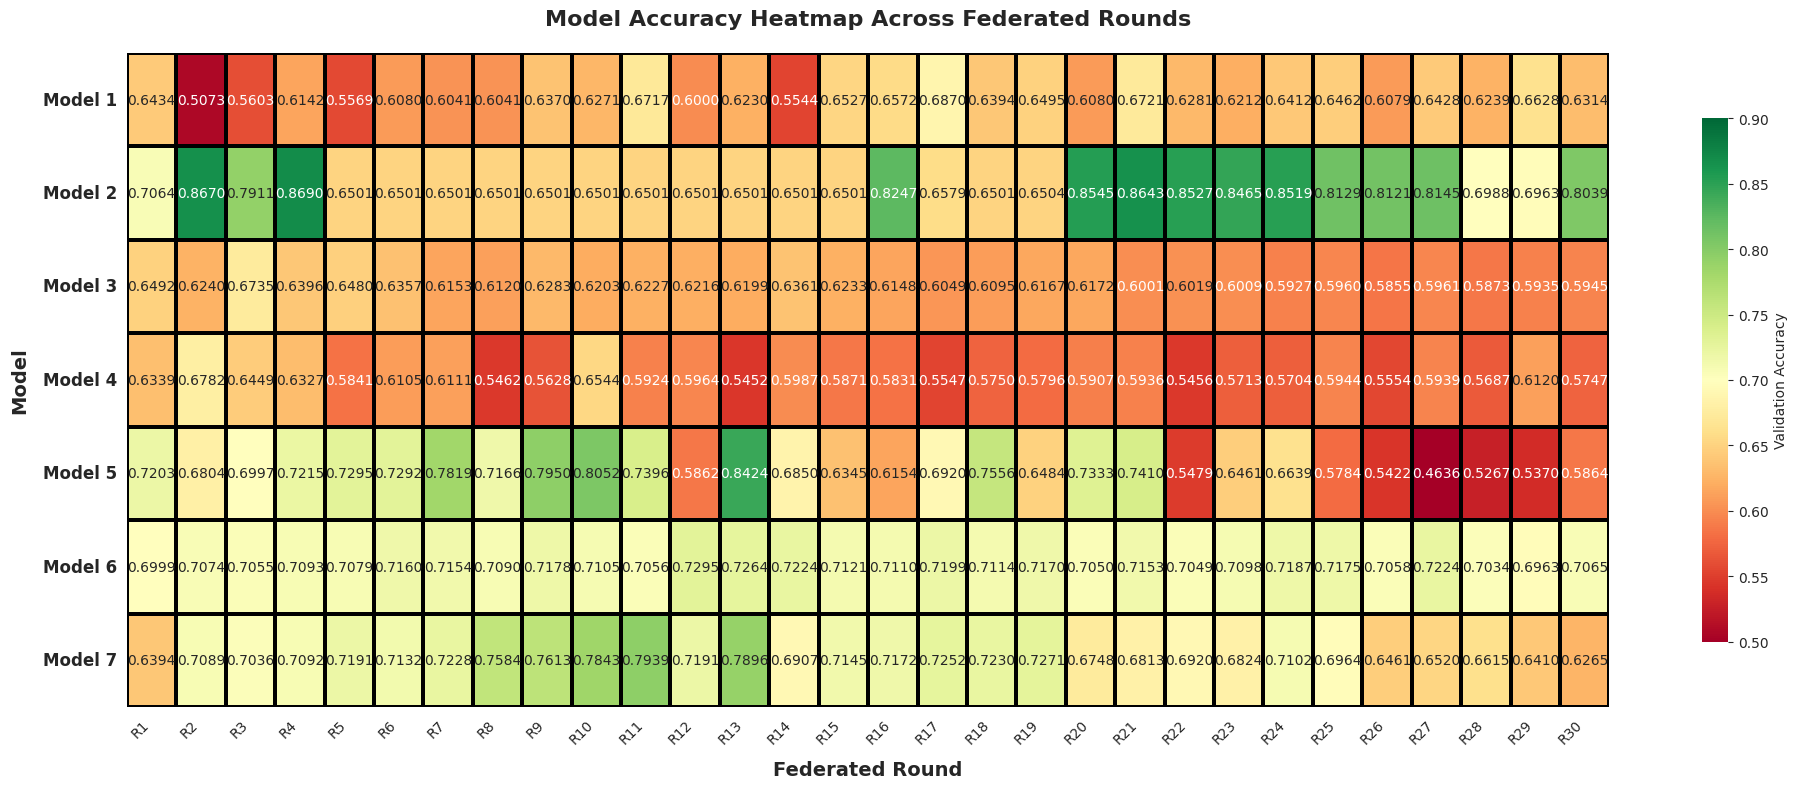


ACCURACY HEATMAP STATISTICS

Best Performances:
   Model 1: 0.6870 at Round 17
   Model 2: 0.8690 at Round 4
   Model 3: 0.6735 at Round 3
   Model 4: 0.6782 at Round 2
   Model 5: 0.8424 at Round 13
   Model 6: 0.7295 at Round 12
   Model 7: 0.7939 at Round 11

Round-by-Round Average Accuracy:
   Round  1: 0.6703
   Round  2: 0.6819
   Round  3: 0.6826
   Round  4: 0.6994
   Round  5: 0.6565
   Round  6: 0.6661
   Round  7: 0.6715
   Round  8: 0.6566
   Round  9: 0.6789
   Round 10: 0.6931
   Round 11: 0.6823
   Round 12: 0.6433
   Round 13: 0.6852
   Round 14: 0.6482
   Round 15: 0.6535
   Round 16: 0.6748
   Round 17: 0.6631
   Round 18: 0.6663
   Round 19: 0.6555
   Round 20: 0.6834
   Round 21: 0.6954
   Round 22: 0.6533
   Round 23: 0.6683
   Round 24: 0.6784
   Round 25: 0.6631
   Round 26: 0.6364
   Round 27: 0.6408
   Round 28: 0.6243
   Round 29: 0.6341
   Round 30: 0.6463



In [ ]:
print("\n" + "="*60)
print("📊 ACCURACY HEATMAP - SINGLE PLOT (FIXED)")
print("="*60)

import matplotlib.pyplot as plt
import numpy as np
import joblib
import seaborn as sns
import os

# Create output directory
os.makedirs('visualizations', exist_ok=True)

# Load federated training histories
try:
    federated_histories = joblib.load('models/ultra_ensemble_federated/training_histories.pkl')
    fed_config = joblib.load('models/ultra_ensemble_federated/federated_config.pkl')

    print(f"\n✓ Loaded training histories for {len(federated_histories)} models")
    print(f"✓ Federated config: {fed_config['num_rounds']} rounds")

except FileNotFoundError:
    print("\n❌ Error: Federated training histories not found.")
    print("Please run the federated learning training script first!")
    exit()

# ===== CREATE ACCURACY HEATMAP =====
fig, ax = plt.subplots(figsize=(20, 8))

# Build accuracy matrix (Models × Rounds)
accuracy_matrix = np.array([history['val_accuracy'] for history in federated_histories])

# Create heatmap
sns.heatmap(accuracy_matrix,
            annot=True,  # Show values
            fmt='.4f',   # Format to 4 decimals
            cmap='RdYlGn',  # Red-Yellow-Green colormap
            vmin=0.5,    # Min value for color scale
            vmax=0.9,    # Max value for color scale
            cbar_kws={'label': 'Validation Accuracy', 'shrink': 0.8},
            linewidths=1.5,
            linecolor='black',
            ax=ax,
            square=False)

# ===== CUSTOMIZE LABELS =====
model_labels = [f'Model {i+1}' for i in range(len(federated_histories))]
round_labels = [f'R{i+1}' for i in range(fed_config['num_rounds'])]

ax.set_xticklabels(round_labels, fontsize=10, rotation=45, ha='right')
ax.set_yticklabels(model_labels, fontsize=12, fontweight='bold', rotation=0)

ax.set_xlabel('Federated Round', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Model', fontsize=14, fontweight='bold', labelpad=10)

# REMOVED EMOJI - Use plain text title instead
ax.set_title('Model Accuracy Heatmap Across Federated Rounds',
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('visualizations/accuracy_heatmap_single_fixed.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: visualizations/accuracy_heatmap_single_fixed.png")
plt.show()

# ===== PRINT STATISTICS =====
print("\n" + "="*80)
print("ACCURACY HEATMAP STATISTICS")
print("="*80)

print(f"\nBest Performances:")
for i, history in enumerate(federated_histories):
    best_acc = np.max(history['val_accuracy'])
    best_round = np.argmax(history['val_accuracy']) + 1
    print(f"   Model {i+1}: {best_acc:.4f} at Round {best_round}")

print(f"\nRound-by-Round Average Accuracy:")
for round_idx in range(fed_config['num_rounds']):
    round_accs = [history['val_accuracy'][round_idx] for history in federated_histories]
    mean_acc = np.mean(round_accs)
    print(f"   Round {round_idx+1:2d}: {mean_acc:.4f}")

print("\n" + "="*80)
